In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [3]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [4]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

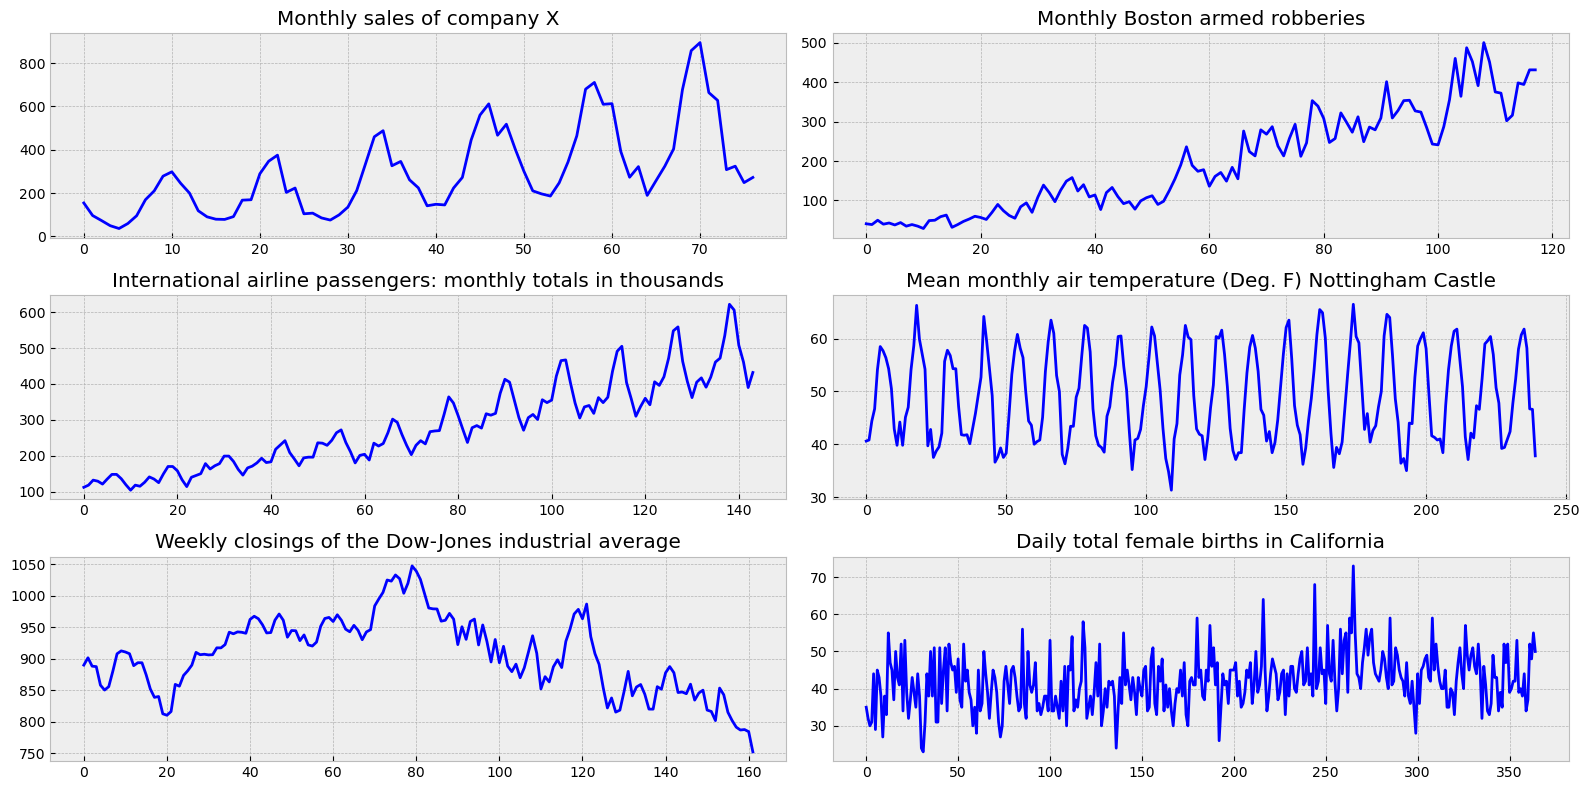

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

По визуальному анализу только последний график может быть стационарным.


Функции для проверки стационарности:

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## daily-total-female-births-in-cal
Сначала для стационарного ряда построим.

In [73]:
series = pd.read_csv("Series//daily-total-female-births-in-cal.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


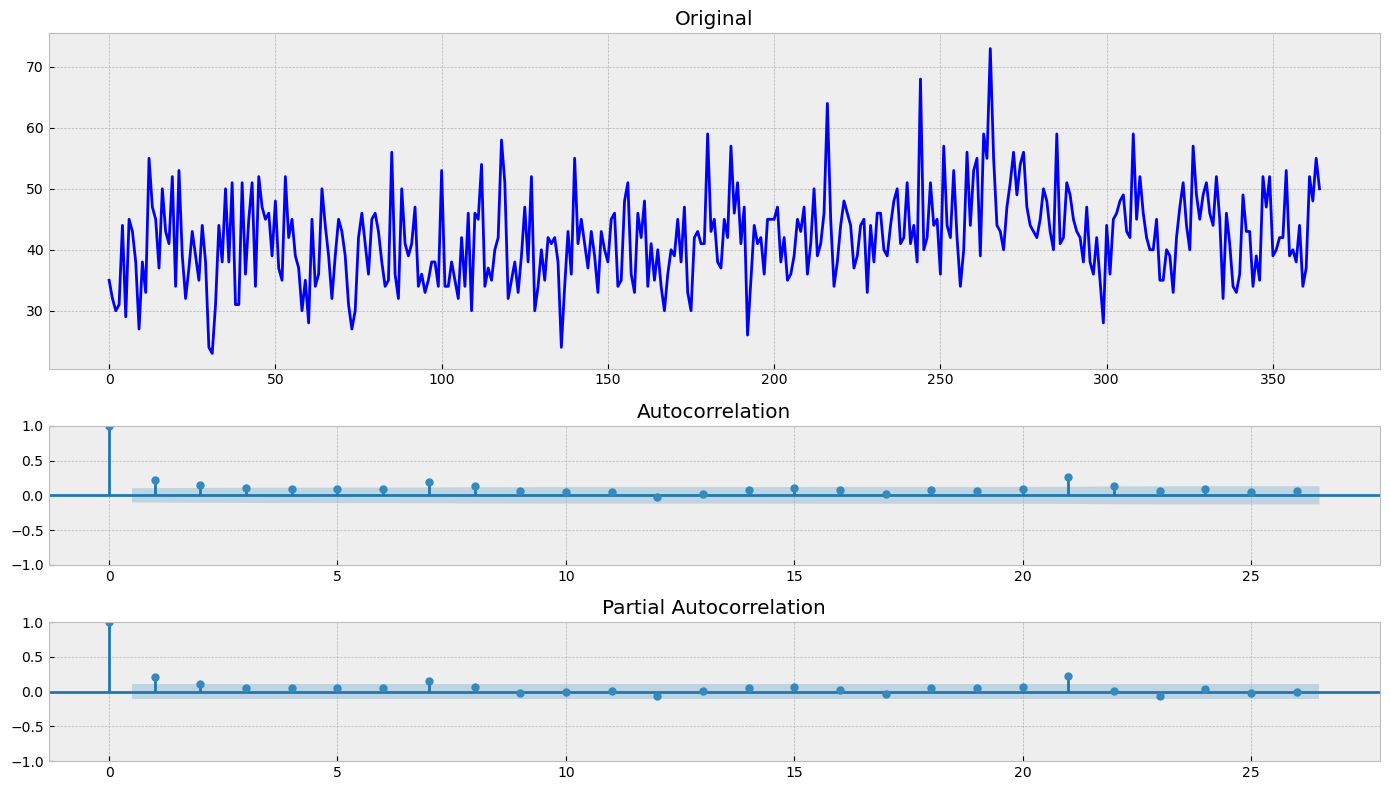

In [74]:
tsplot(series) #если p-value меньше чем 0.5, значит временной ряд стационарен

ARMA с вручную подобранными P D Q:

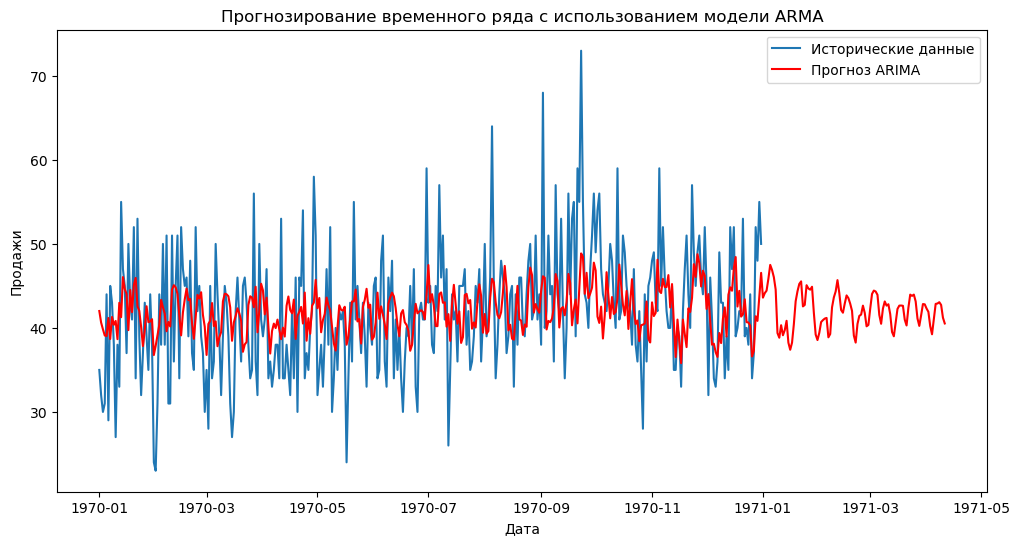

In [75]:
# Оценка модели ARMA
p = 10  # Порядок авторегрессии (AR)
d = 0  # Порядок разностей (d), дифференцирование. зануляем (ряд уже стационарен), получается модель ARMA
q = 10  # Порядок скользящего среднего (MA)
model_arima = sm.tsa.ARIMA(series, order=(p, d, q)).fit()

# Прогноз на 100 дней вперед
forecast_horizon = 100
forecast_arma = model_arima.predict(start=0, end=len(series) + forecast_horizon)

# Создание индекса для прогнозного периода
forecast_index_arima = pd.date_range(start=series.index[0], periods=len(forecast_arma))

# Визуализация исторических данных и прогноза
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Исторические данные')
plt.plot(forecast_index_arima, forecast_arma, label='Прогноз ARIMA', color='red')
plt.title('Прогнозирование временного ряда с использованием модели ARMA')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.show()

## Monthly sales of company X
Теперь для другого ряда применим ARIMA.

In [77]:
series = pd.read_csv("Series//monthly-sales-of-company-x-jan-6.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


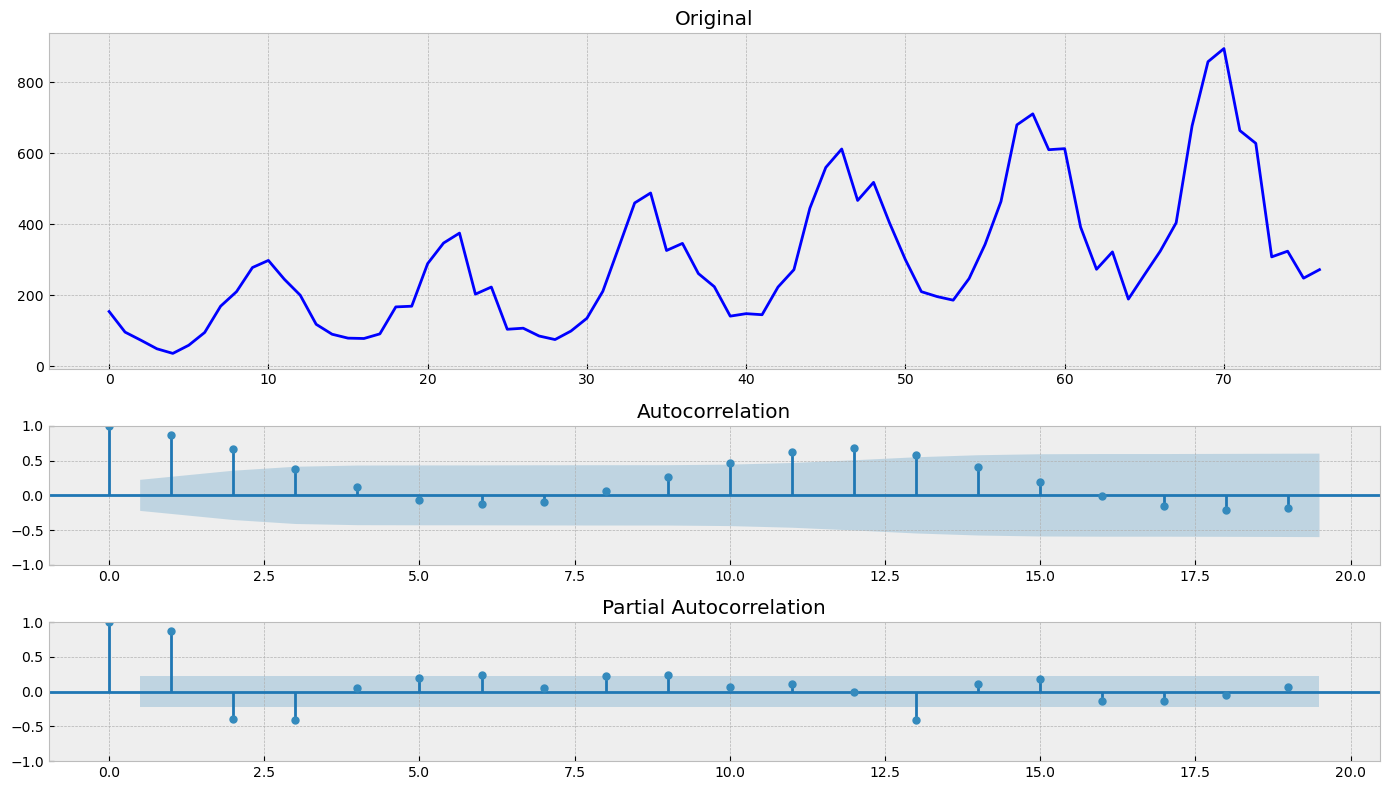

In [78]:
tsplot(series)

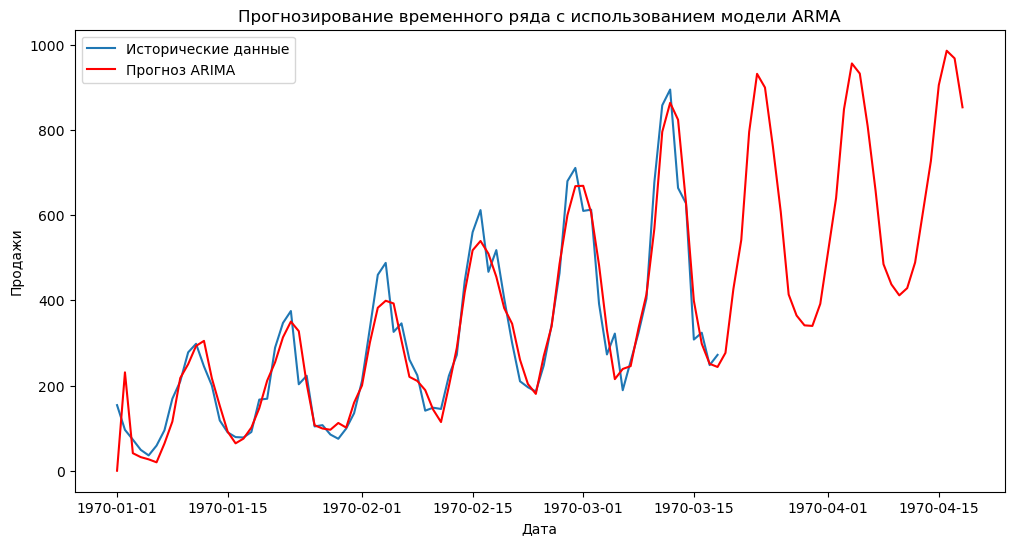

In [79]:
# Оценка модели ARMA
p = 10  # Порядок авторегрессии (AR)
d = 2  # Порядок разностей (d), дифференцирование. не буду занулять, так как во временном ряде явно есть тренд
q = 10  # Порядок скользящего среднего (MA)
model_arima = sm.tsa.ARIMA(series, order=(p, d, q)).fit()

# Прогноз на 30 дней вперед
forecast_horizon = 30
forecast_arma = model_arima.predict(start=0, end=len(series) + forecast_horizon)

# Создание индекса для прогнозного периода
forecast_index_arima = pd.date_range(start=series.index[0], periods=len(forecast_arma))

# Визуализация исторических данных и прогноза
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Исторические данные')
plt.plot(forecast_index_arima, forecast_arma, label='Прогноз ARIMA', color='red')
plt.title('Прогнозирование временного ряда с использованием модели ARMA')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.show()

Тут хорошо видна цикличность и тренд, но как будто не учитываются сезонные колебания.

Попробуем автоматически подобрать параметры модели:

In [80]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
p = range(0,15)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
    model_test = ARIMA(series, order = params, enforce_stationarity=False)
    result_test = model_test.fit()
    if result_test.aic < best_aic:
        best_pdq = params
        best_aic = result_test.aic
print(best_pdq, best_aic) # позволяет нам сравнить разные модели и определить, какая из них лучше. 
#AIC помогает оценить, насколько модель соответствует данным, учитывая ее сложность.

(14, 2, 1) 669.0432284115396


Параметры получили, построим заново модель:

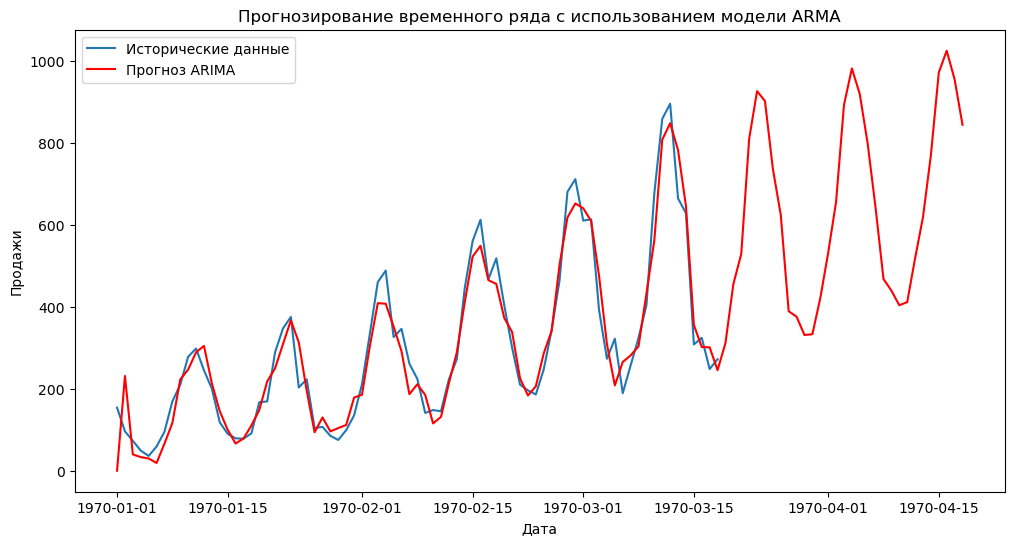

In [88]:
p = 14  # Порядок авторегрессии (AR)
d = 2  # Порядок разностей (d), дифференцирование. не буду занулять, так как во временном ряде явно есть тренд
q = 1  # Порядок скользящего среднего (MA)
model_arima = sm.tsa.ARIMA(series, order=(p, d, q)).fit()

# Прогноз на 30 дней вперед
forecast_horizon = 30
forecast_arma = model_arima.predict(start=0, end=len(series) + forecast_horizon)

# Создание индекса для прогнозного периода
forecast_index_arima = pd.date_range(start=series.index[0], periods=len(forecast_arma))

# Визуализация исторических данных и прогноза
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label='Исторические данные')
plt.plot(forecast_index_arima, forecast_arma, label='Прогноз ARIMA', color='red')
plt.title('Прогнозирование временного ряда с использованием модели ARMA')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.show()